# Cross Selling

[Cross selling](https://www.oberlo.com/ecommerce-wiki/cross-selling) the practice of selling additional products to an existing customer by analyzing the customer’s shopping patterns trends. Cross-selling is famously exemplified by Amazon’s “Customers Who Bought This Item Also Bought” feature. The idea of cross selling can be extended to any organization, irrespective of whether it is an online or offline retailer or whether it is selling its products to the end users of whole sellers.

In this notebook, we explore [Association Rules Mining](https://www.geeksforgeeks.org/association-rule/), using [FP-Growth algorithm](https://www.softwaretestinghelp.com/fp-growth-algorithm-data-mining/) implemented in the [orange3-associate package](https://pypi.org/project/Orange3-Associate/), for a [market basket analysis](https://smartbridge.com/market-basket-analysis-101/), which identified which combination of products are often purchased by customers. Then, we will apply the concepts to an `retail transactions dataset`.



## Set up the working directory & Import packages ##

In [ ]:
!pip install orange3-associate

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from Orange.data import Domain,Table,DiscreteVariable
from orangecontrib.associate.fpgrowth import *

In [ ]:
# Move to the working directory on Google Drive as using Google Colab
import os
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  PROJECT_ROOT ="/content/drive/MyDrive/GitHub/Customer_Segmentation_Effective_Cross_Selling"
else:
  PROJECT_ROOT ="."
os.chdir(PROJECT_ROOT)
!pwd

Running on CoLab
/content/drive/MyDrive/GitHub/Customer_Segmentation_Effective_Cross_Selling


# 1/ Loading data

In [ ]:
data = pd.read_csv("DATA/grocery_dataset_df.csv")
data.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,1,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,NaN
1,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,1,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1,NaN
2,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,1,0,NaN
3,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1,NaN
4,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,1,0,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Columns: 169 entries, Instant food products to zwieback
dtypes: int64(169)
memory usage: 12.7 MB


# 2/ Cleaning data

In [ ]:
# replace all NaN with Os
data = data.fillna(0).astype("int64")
data.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# 3/ Exploring data

## 3.1 Amount of items purchased on each transaction

In [ ]:
amount_each_transaction = data.sum(axis=1)
print(amount_each_transaction[0:5])

0    4
1    3
2    1
3    4
4    4
dtype: int64


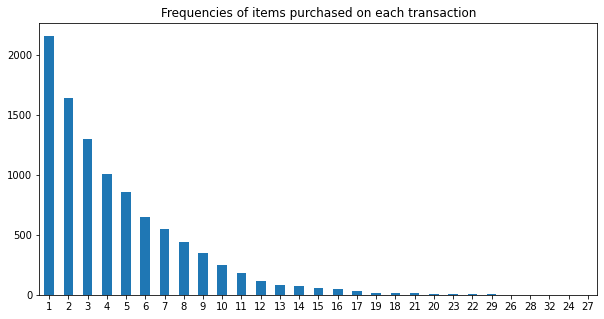

In [ ]:
freq_items = amount_each_transaction.value_counts()
freq_items.plot.bar(rot=0,figsize=(10,5),title="Frequencies of items purchased on each transaction")
plt.show()

## 3.2 Features (purchased items) - Top lists:

Total purchased items = 43367


,item_name,item_count,item_pct,cumsum_pct
0,whole milk,2513,5.794729,5.794729
1,other vegetables,1903,4.388129,10.182858
2,rolls/buns,1809,4.171375,14.354232
3,soda,1715,3.954620,18.308852
4,yogurt,1372,3.163696,21.472548
5,bottled water,1087,2.506514,23.979062
6,root vegetables,1072,2.471926,26.450988
7,tropical fruit,1032,2.379690,28.830678
8,shopping bags,969,2.234418,31.065096
9,sausage,924,2.130652,33.195748


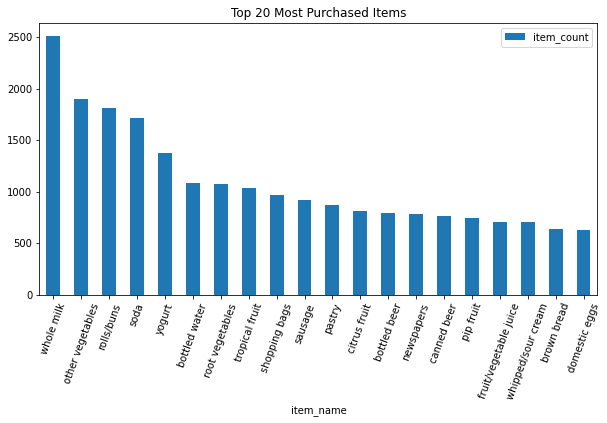

In [ ]:
# summary table ( sorted by "count") of all items:
item_summary = data.sum().sort_values(ascending=False).reset_index()
item_summary.rename(columns={"index":"item_name",0:"item_count"},inplace=True)
total_item_count = item_summary.item_count.sum()        # total amount of all purchased items
item_summary["item_pct"]= item_summary.item_count/total_item_count*100
item_summary["cumsum_pct"] = item_summary.item_pct.cumsum()

print(f"Total purchased items = {total_item_count}")

# top 5 most purchased items
display(item_summary.head(21))

# plot top 20 most purchased items
item_summary.head(20).plot(x="item_name", y="item_count",kind='bar', figsize=(10,5),title="Top 20 Most Purchased Items",rot=70)

This shows us that the top five items are responsible for 21.47% of the entire sales and only the top 20 items are responsible for over 50% of the sales! This is important for us, as we don’t want to find association rules for items which are bought very infrequently. With this information we can limit the items we want to explore for creating our association rules. This also helps us in keeping our possible itemset number to a manageable figure.

# 4/ Association Data-Mining: FP Growth Algorithm 

## 4.1 Prepare a desired subset for the algorithm: 
- It will contain just the items we are interested (i.e, the items contribute 40% to the total sales)
- It will hold all transactions with at least 2 purchased items.

In [ ]:
# summary table of first items that contributes 40% to the total sales
summary_c40 =  item_summary[item_summary.cumsum_frac <= 0.4]
display(summary_c40)
# list of the features (items) whose purchased amounts contribute 40% to the total sales
features_c40 = list(summary_c40.item_name)

,item_name,item_count,item_frac,cumsum_frac
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


In [ ]:
# subset dataframe that contains all transactions, but with just the items (i.e, 13) we are interested
data_c40_all_rows = data[features_c40]
data_c40_all_rows['Amount'] = data_c40_all_rows.sum(axis=1)

# subset that contains the transactions just with ast least 2 items
data_c40 = data_c40_all_rows[data_c40_all_rows['Amount'] >1][features_c40]
data_c40.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4585 entries, 1 to 9834
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   whole milk        4585 non-null   int64
 1   other vegetables  4585 non-null   int64
 2   rolls/buns        4585 non-null   int64
 3   soda              4585 non-null   int64
 4   yogurt            4585 non-null   int64
 5   bottled water     4585 non-null   int64
 6   root vegetables   4585 non-null   int64
 7   tropical fruit    4585 non-null   int64
 8   shopping bags     4585 non-null   int64
 9   sausage           4585 non-null   int64
 10  pastry            4585 non-null   int64
 11  citrus fruit      4585 non-null   int64
 12  bottled beer      4585 non-null   int64
dtypes: int64(13)
memory usage: 501.5 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


- Now, there are only 13 items responsible for 40% of sales and 4585 transactions that have those items along with other items

## 4.2/ Set up Orange table

In [ ]:
# set up Orange tables
domain_data_c40 = Domain([DiscreteVariable.make(name=item,values=['0', '1']) for item in features_c40])
org_data_c40 = Table.from_numpy(domain=domain_data_c40, 
                                X=data_c40.to_numpy(),
                                Y= None)
org_data_c40_en, mapping = OneHot.encode(org_data_c40, include_class=False)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## 4.3/ Set up the Rules

In [ ]:
min_support = 0.01
num_trans = int(data_c40.shape[0] * min_support)
itemsets = dict(frequent_itemsets(org_data_c40_en,min_support=min_support))
print(f"Number of required transactions = {num_trans}")
len(itemsets)


Number of required transactions = 45


166886

## 4.4/ Generate the Rules
Let’s take some sample rules generated using transactions that explain: 
-  40% of total sales, 
- min-support of 1% (required number of transactions >=45) and, 
- confidence greater than 30%. 

In [ ]:
confidence = 0.3
rules_df = pd.DataFrame()

rules = [(P, Q, supp, conf) for P, Q, supp, conf in association_rules(itemsets, confidence) if len(Q) == 1 ]

names = {item: f"{var.name} {val}" for item, var, val in OneHot.decode(mapping, org_data_c40, mapping)}

eligible_ante = [v for k,v in names.items() if v.endswith("1")]

N = data_c40.shape[0]

rule_stats = list(rules_stats(rules, itemsets, N))

rule_list_df = []
for ex_rule_frm_rule_stat in rule_stats:
    ante = ex_rule_frm_rule_stat[0]            
    cons = ex_rule_frm_rule_stat[1]
    named_cons = names[next(iter(cons))]
    if named_cons in eligible_ante:
        rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
        ante_rule = ', '.join(rule_lhs)
        if ante_rule and len(rule_lhs)>1 :
            rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                         'confidence' : ex_rule_frm_rule_stat[3],
                         'coverage' : ex_rule_frm_rule_stat[4],
                         'strength' : ex_rule_frm_rule_stat[5],
                         'lift' : ex_rule_frm_rule_stat[6],
                         'leverage' : ex_rule_frm_rule_stat[7],
                         'antecedent': ante_rule,
                         'consequent':named_cons[:-2] }
            rule_list_df.append(rule_dict)
rules_df = pd.DataFrame(rule_list_df)

print(f"Raw rules data frame of {rules_df.shape[0]} rules generated")
if not rules_df.empty:
    pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
else:
    print("Unable to generate any rule")


Raw rules data frame of 16628 rules generated


### Sorting rules in our Grocery Dataset

In [ ]:
pruned_rules_df[['antecedent','consequent','support','confidence','lift']].groupby('consequent')\
    .max().reset_index()\
    .sort_values(['lift', 'support','confidence'],ascending=False)

,consequent,antecedent,support,confidence,lift
4,root vegetables,"yogurt, tropical fruit",228,0.463636,2.230611
5,sausage,"shopping bags, rolls/buns",59,0.393162,2.201037
8,tropical fruit,"yogurt, root vegetables",92,0.429907,2.156588
1,citrus fruit,"whole milk, other vegetables, tropical fruit",66,0.333333,2.125637
10,yogurt,"whole milk, tropical fruit",199,0.484211,1.891061
2,other vegetables,"yogurt, whole milk, tropical fruit",228,0.643836,1.826724
6,shopping bags,"soda, sausage",50,0.304878,1.782992
0,bottled water,"yogurt, soda",59,0.333333,1.707635
9,whole milk,"yogurt, tropical fruit",228,0.754098,1.703222
3,rolls/buns,"yogurt, tropical fruit",97,0.522222,1.679095


The pattern that the rule states in the equation is easy to understand—people who bought `yogurt` and `tropical fruit` also tend to buy `root vegetables`. Let’s try to understand the metrics: 
- `Support` of the rule is 228, which means, all the items together appear in 228 transactions in the dataset. 
- `Confidence` of the rule is 46%, which means that 46% of the time the antecedent items occurred we also had the consequent in the transaction (i.e. 46% of times, customers who bought `yogurt` and `tropical fruit` also tend to buy `root vegetables`).
- `Lift` means that the probability of finding `root vegetables`
in the transactions which have `yogurt` and `tropical fruit` is greater than the normal probability of finding `root vegetables` in the previous transactions (2.23). Typically, a lift value of 1 indicates that the probability of occurrence of the antecedent and consequent together are independent of each other. Hence, ***the idea is to look for rules having a lift much greater than 1***. In our case, all the previously mentioned rules are good quality rules.